In [1]:
import requests
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from absl import logging
logging.set_verbosity(logging.ERROR)

2024-05-20 23:49:50.415976: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-20 23:49:50.421663: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-20 23:49:50.493496: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-20 23:49:52.812188: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:

dataset_url = 'https://www.cryptodatadownload.com/cdd/Gemini_BTCEUR_d.csv'
destination_file = 'Gemini_BTCEUR_d.csv'

response = requests.get(dataset_url)

if response.status_code == 200:
    with open(destination_file, 'wb') as file:
        file.write(response.content)
    print(f'Dataset downloaded successfully to {destination_file}')
else:
    print(f'Failed to download dataset. Status code: {response.status_code}')
    
csv_file_path = 'Gemini_BTCEUR_d.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path, skiprows=[0])
# Display the DataFrame


Dataset downloaded successfully to Gemini_BTCEUR_d.csv


In [3]:
df

,unix,date,symbol,open,high,low,close,Volume BTC,Volume EUR
0,1716076800000,2024-05-19 00:00:00,BTC/EUR,61656.61,62408.48,60987.71,60987.71,0.091347,5571.019950
1,1715990400000,2024-05-18 00:00:00,BTC/EUR,61463.12,61932.87,61463.12,61656.61,0.147753,9109.978076
2,1715904000000,2024-05-17 00:00:00,BTC/EUR,60151.83,62470.95,60083.33,61463.12,1.163722,71525.967108
3,1715817600000,2024-05-16 00:00:00,BTC/EUR,60615.95,61256.90,57301.05,60151.83,0.334281,20107.605463
4,1715731200000,2024-05-15 00:00:00,BTC/EUR,56969.36,60699.58,56938.09,60615.95,0.505893,30665.213889
...,...,...,...,...,...,...,...,...,...
1653,1603857600000,2020-10-28 04:00:00,BTC/EUR,0.00,11441.37,0.00,11153.76,0.471273,5256.460917
1654,1603771200000,2020-10-27 04:00:00,BTC/EUR,0.00,0.00,0.00,0.00,0.000000,0.000000
1655,1603684800000,2020-10-26 04:00:00,BTC/EUR,0.00,0.00,0.00,0.00,0.000000,0.000000
1656,1603598400000,2020-10-25 04:00:00,BTC/EUR,0.00,0.00,0.00,0.00,0.000000,0.000000


In [4]:
columns_to_drop = ['symbol','unix', 'Volume EUR', 'Volume BTC', 'high', 'open', 'low']
df = df[df['close'] != 0]

df.drop(columns=columns_to_drop, inplace=True)
df

/tmp/ipykernel_21132/3768464653.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=columns_to_drop, inplace=True)


,date,close
0,2024-05-19 00:00:00,60987.71
1,2024-05-18 00:00:00,61656.61
2,2024-05-17 00:00:00,61463.12
3,2024-05-16 00:00:00,60151.83
4,2024-05-15 00:00:00,60615.95
...,...,...
1649,2020-11-01 04:00:00,11794.98
1650,2020-10-31 04:00:00,11902.44
1651,2020-10-30 04:00:00,11602.24
1652,2020-10-29 04:00:00,11605.42


/tmp/ipykernel_21132/3707028640.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])


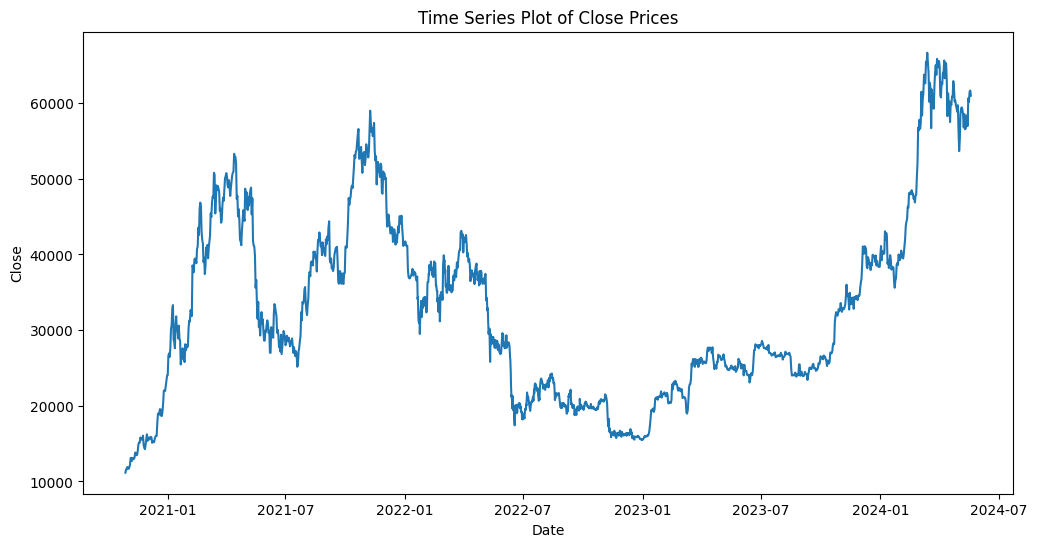

In [5]:
df['date'] = pd.to_datetime(df['date'])

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['close'])
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Time Series Plot of Close Prices')
plt.show()

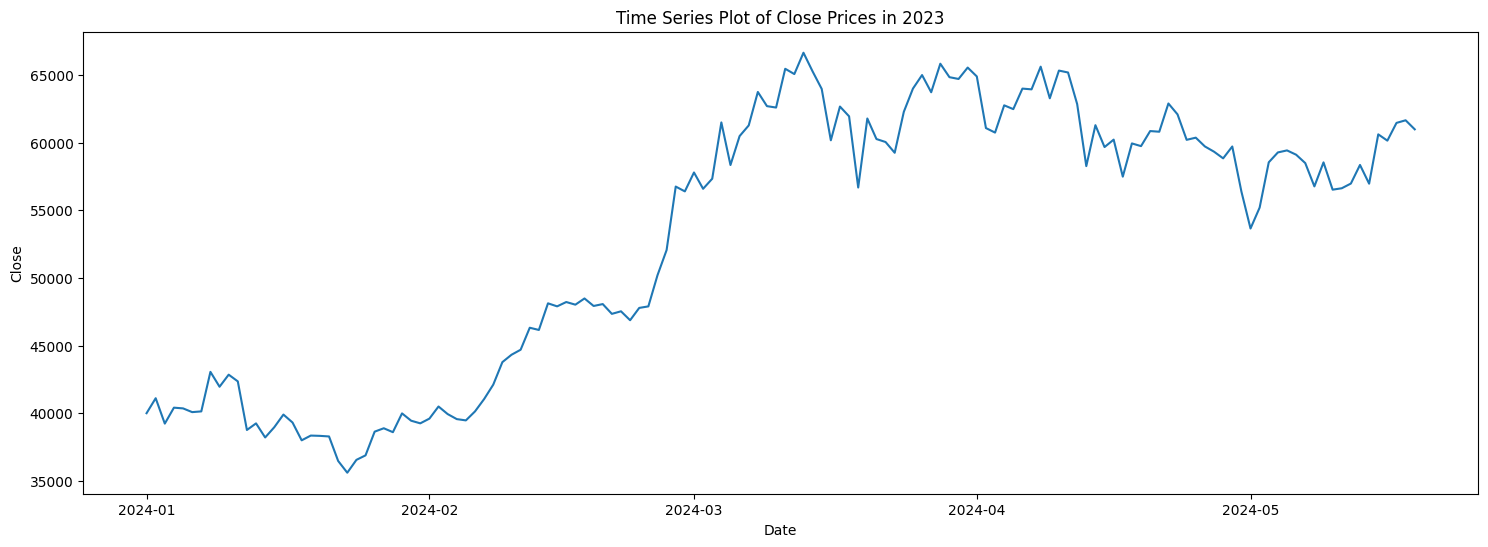

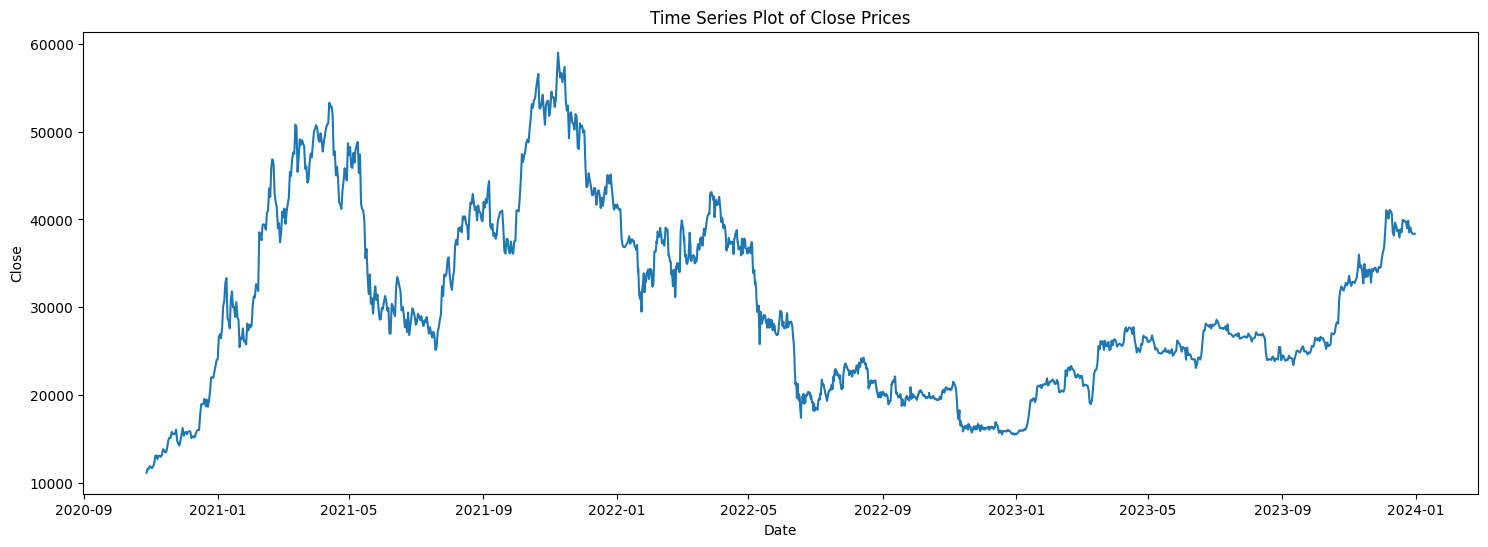

In [6]:
test_set = df[df['date'].dt.year == 2024]

# Training set
train_set = df[df['date'].dt.year != 2024]
# Plotting
plt.figure(figsize=(18, 6))
plt.plot(test_set['date'], test_set['close'])
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Time Series Plot of Close Prices in 2023')
plt.show()

plt.figure(figsize=(18, 6))
plt.plot(train_set['date'], train_set['close'])
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Time Series Plot of Close Prices')
plt.show()

In [7]:
valid = np.array(test_set['close'])
train = np.array(train_set['close'])

valid = valid[::-1]
train = train[::-1]

In [8]:
def plot_time_series(data):
    indices = np.arange(len(data))
    
    plt.figure(figsize=(10, 6))
    plt.plot(indices, data, label='Time Series Data')
    plt.title('Time Series Plot')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()


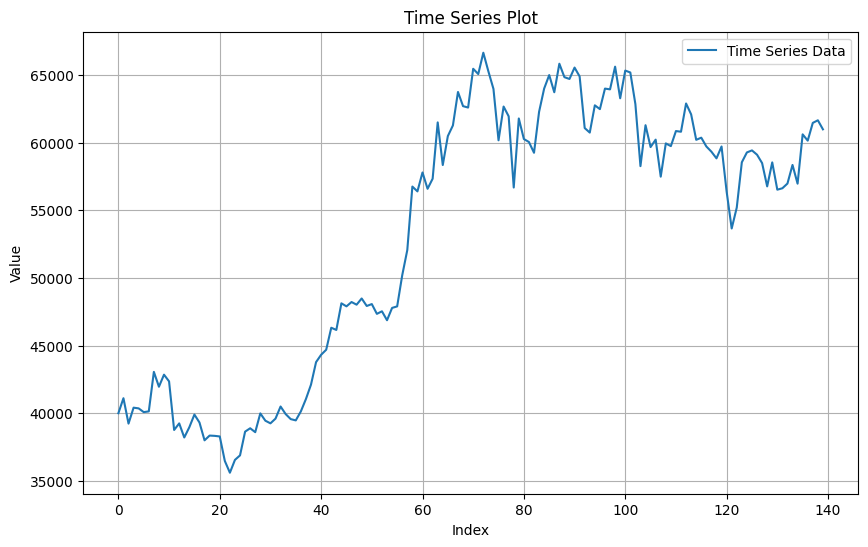

In [9]:
plot_time_series (valid)

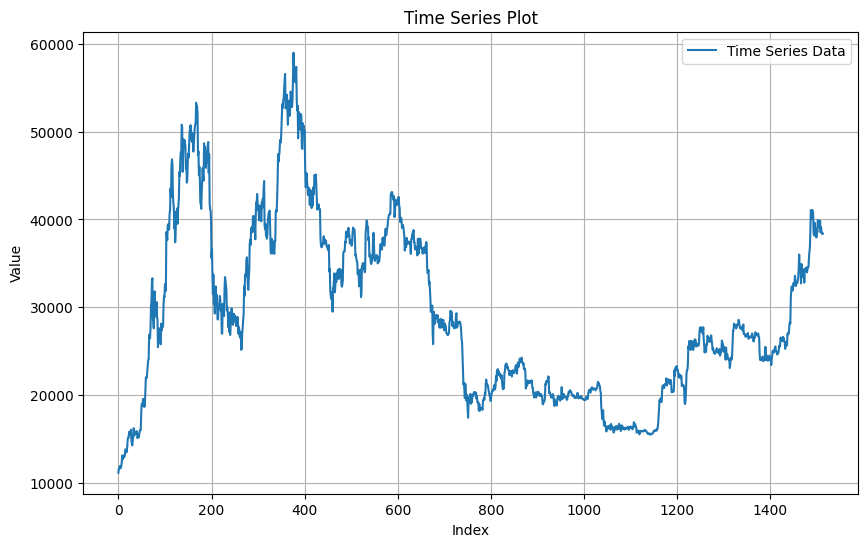

In [10]:
plot_time_series (train)

In [11]:
def normalize_data(train_data, valid_data, lower_percent, upper_percent):
    """
    Normalize training and validation data to a custom range where a certain percentage is mapped to values less than zero.
    
    Parameters:
    train_data (array-like): The training data to be normalized.
    valid_data (array-like): The validation data to be normalized.
    lower_percent (float): The percentage of the range to map to values less than zero.
    upper_percent (float): The percentage of the range to map to values greater than zero.
    
    Returns:
    tuple: A tuple containing the normalized training and validation data.
    """
    min_val = min(train_data)
    max_val = max(train_data)
    range_of_values = np.ptp(train_data) 
    min_val = min_val - range_of_values*5
    max_val = max_val + range_of_values*5
    normalized_train_data = [(x - min_val) / (max_val - min_val) for x in train_data]
    normalized_valid_data = [(x - min_val) / (max_val - min_val) for x in valid_data]
    return normalized_train_data, normalized_valid_data

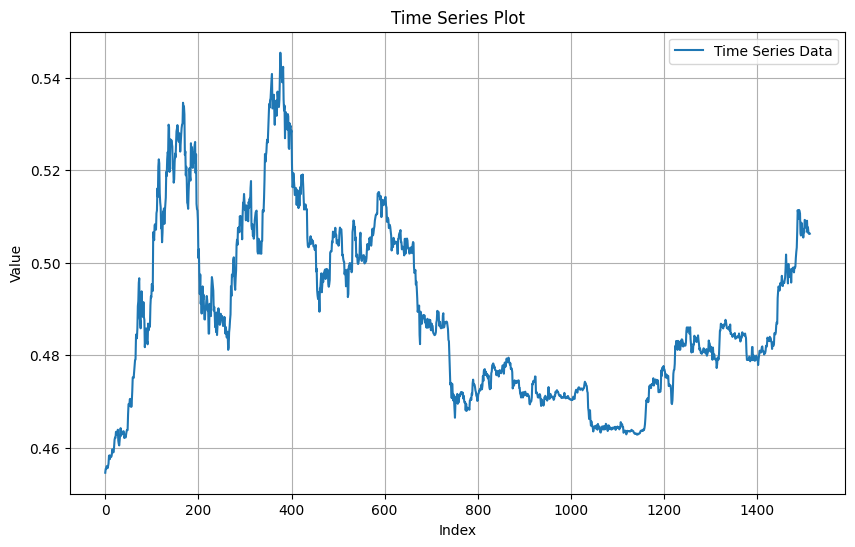

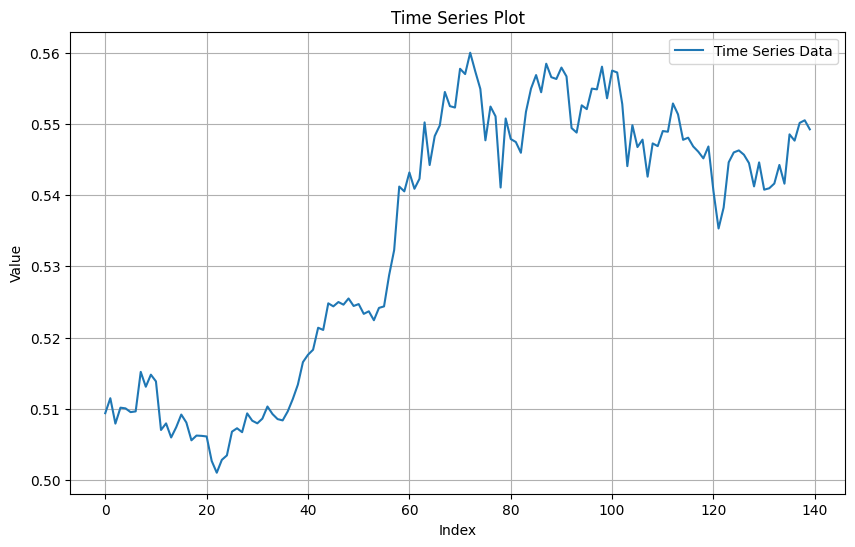

In [12]:
lower_percent = 5
upper_percent = 5

x_train_reshaped = train.reshape(-1, 1)
x_valid_reshaped = valid.reshape(-1, 1)

x_train_reshaped, x_valid_reshaped = normalize_data(x_train_reshaped, x_valid_reshaped, lower_percent , upper_percent)

plot_time_series(x_train_reshaped)
plot_time_series(x_valid_reshaped)

In [13]:
window_size = 30

x_train_window = []
y_train_window = []
x_valid_window = []
y_valid_window = []

x_train_reshaped = np.array(x_train_reshaped)
x_valid_reshaped = np.array(x_valid_reshaped)

for i in range(window_size, x_train_reshaped.shape[0] - 7):  # Adjusted to leave room for taking the mean of the next 7 days
    x_train_window.append(x_train_reshaped[i-window_size:i, 0])
    y_train_window.append(np.mean(x_train_reshaped[i:i+7, 0]))  # Taking the mean of the next 7 days

for i in range(window_size, x_valid_reshaped.shape[0] - 7):  # Adjusted to leave room for taking the mean of the next 7 days
    x_valid_window.append(x_valid_reshaped[i-window_size:i, 0])
    y_valid_window.append(np.mean(x_valid_reshaped[i:i+7, 0]))  # Taking the mean of the next 7 days

X_train, y_train, X_valid, y_valid = np.array(x_train_window), np.array(y_train_window), np.array(x_valid_window), np.array(y_valid_window)


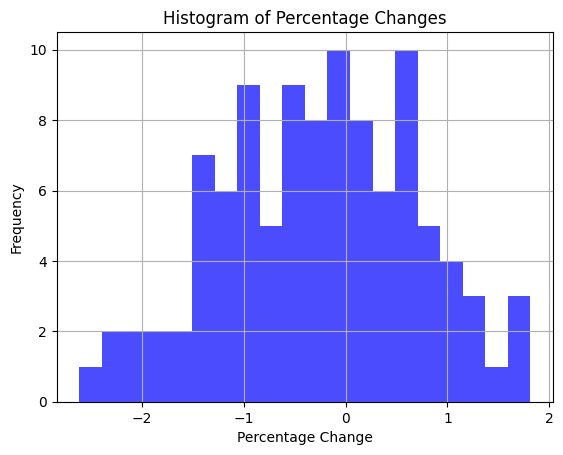

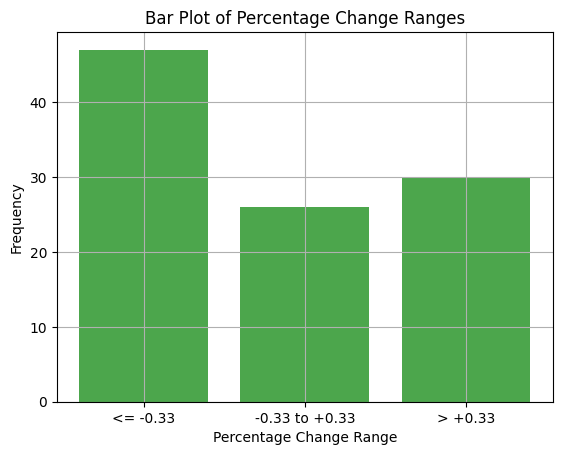

In [14]:
import matplotlib.pyplot as plt

# List to store percentage changes
percentage_changes = []

# Calculate percentage changes and store them
for i in range(len(y_valid)):
    x_element = X_valid[i][29]  # Accessing the 30th element of each row
    y_element = y_valid[i]
    
    percentage_change = ((x_element - y_element) / y_element) * 100
    percentage_changes.append(percentage_change)

# Plot histogram
plt.hist(percentage_changes, bins=20, color='blue', alpha=0.7)
plt.xlabel('Percentage Change')
plt.ylabel('Frequency')
plt.title('Histogram of Percentage Changes')
plt.grid(True)
plt.show()

import numpy as np

# Define the ranges for the bars
ranges = [float('-inf'), -0.33, 0.33, float('inf')]

# Initialize counts for each range
counts = [0] * (len(ranges) - 1)

# Count the occurrences of percentage changes in each range
for change in percentage_changes:
    for i in range(len(ranges) - 1):
        if ranges[i] <= change < ranges[i + 1]:
            counts[i] += 1
            break

# Plot the bar chart
plt.bar(['<= -0.33', '-0.33 to +0.33', '> +0.33'], counts, color='green', alpha=0.7)
plt.xlabel('Percentage Change Range')
plt.ylabel('Frequency')
plt.title('Bar Plot of Percentage Change Ranges')
plt.grid(True)
plt.show()

In [15]:
# Calculate percentage changes and update y_train
for i in range(len(y_train)):
    y_train[i] = ((X_train[i][29] - y_train[i]) / y_train[i]) * 100

# Calculate percentage changes and update y_valid
for i in range(len(y_valid)):
    y_valid[i] = ((X_valid[i][29] - y_valid[i]) / y_valid[i]) * 100

# Define the ranges for the classes
class_ranges = [float('-inf'), -0.33, 0.33, float('inf')]

# Update y_train with class labels
for i in range(len(y_train)):
    percentage_change = y_train[i]
    for j in range(len(class_ranges) - 1):
        if class_ranges[j] <= percentage_change < class_ranges[j + 1]:
            y_train[i] = j
            break

# Update y_valid with class labels
for i in range(len(y_valid)):
    percentage_change = y_valid[i]
    for j in range(len(class_ranges) - 1):
        if class_ranges[j] <= percentage_change < class_ranges[j + 1]:
            y_valid[i] = j
            break
            
y_train = y_train.astype(int)
y_valid = y_valid.astype(int)

print (type(y_train[0]))
print (type(y_valid[0]))

<class 'numpy.int64'>
<class 'numpy.int64'>


In [16]:
import os

model_directory = '/home/p/apotoup/DeepNN/LSTM/Bitcoin/Classification/'

smallest_error = 0.0
best_model_info = None

for filename in os.listdir(model_directory):
    if filename.endswith('.keras'):
        model_path = os.path.join(model_directory, filename)
        loaded_model = tf.keras.models.load_model(model_path) 
        y_pred = loaded_model.predict(X_valid)

        # Convert softmax probabilities to class predictions
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Compute accuracy
        accuracy_metric = tf.metrics.Accuracy()
        accuracy_metric.update_state(y_valid, y_pred_classes)
        accuracy = accuracy_metric.result().numpy()  # Extract accuracy value

        print(f"Evaluating model: {filename}")
        print("Validation Accuracy:", accuracy)

        # Check if accuracy is better than previous best
        if accuracy > smallest_error:
            smallest_error = accuracy
            best_model_info = filename

print("Best model found:", best_model_info)
print("Highest Validation Accuracy:", smallest_error)

2024-05-20 23:49:58.670624: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-20 23:49:58.671858: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
Evaluating model: best_model_LSTM_0_50_relu.keras
Validation Accuracy: 0.41747573
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step
Evaluating model: best_model_LSTM_1_50_relu.keras
Validation Accuracy: 0.41747573
1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 372ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f37178ed900> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.